Importing libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import pywt
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt

Setting up the directory for analysis

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [14]:
print(len(cat))
test_filename = cat.iloc[6].filename
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
df = pd.read_csv(csv_file)
df

76


,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


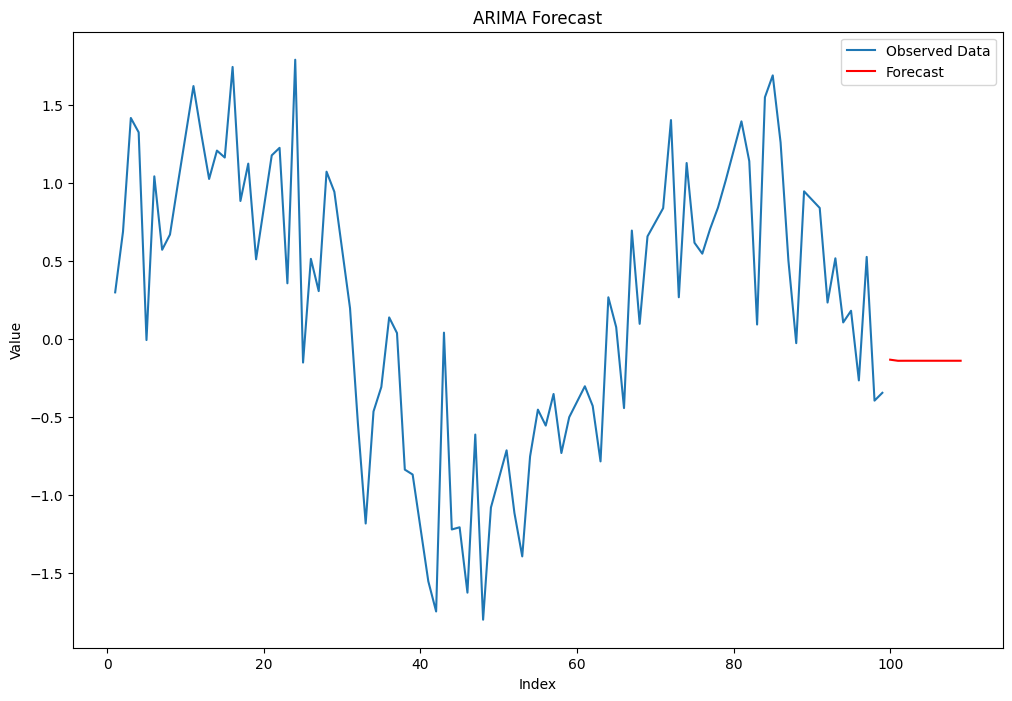

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Sample data: Create a time series with missing values
np.random.seed(0)
data_size = 100
time_series = np.sin(np.linspace(0, 10, data_size)) + np.random.normal(scale=0.5, size=data_size)
time_series[::10] = np.nan  # introduce missing values

# Create DataFrame
df = pd.DataFrame({'value': time_series})

# Fill missing values with interpolation before fitting ARIMA model
df['value'] = df['value'].interpolate(method='linear')

# Fit ARIMA model (example with ARIMA(1,1,1))
model = ARIMA(df['value'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 10 values
forecast = model_fit.forecast(steps=10)

# Plot original data and forecast
plt.figure(figsize=(12, 8))
plt.plot(df['value'], label='Observed Data')
plt.plot(range(len(df), len(df) + 10), forecast, label='Forecast', color='red')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.show()


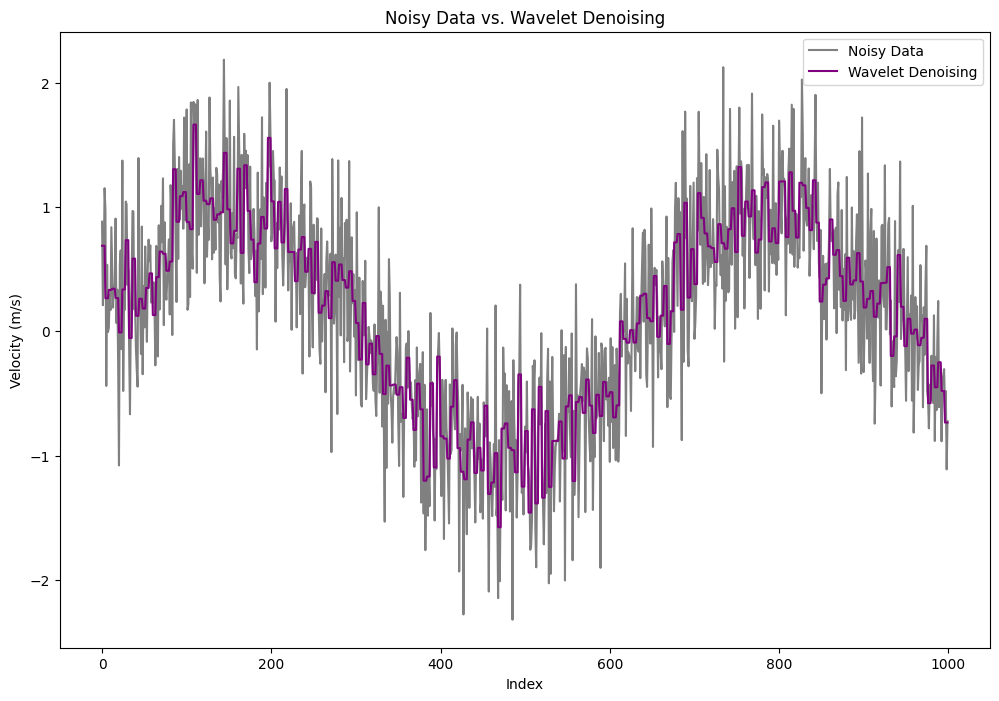

In [4]:


# Sample DataFrame for demonstration
# Replace this with your actual DataFrame
np.random.seed(0)
data_size = 1000
df = pd.DataFrame({
    'velocity(m/s)': np.sin(np.linspace(0, 10, data_size)) + np.random.normal(scale=0.5, size=data_size)
})

def wavelet_denoising(data, wavelet='db1', level=1):
    # Pad data to avoid boundary effects
    pad_width = len(data) // 2
    data_padded = np.pad(data, pad_width, mode='reflect')
    
    coeffs = pywt.wavedec(data_padded, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(data_padded))) * (1 / np.sqrt(2))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    
    denoised_padded = pywt.waverec(coeffs, wavelet)
    
    # Remove padding
    return denoised_padded[pad_width:-pad_width]

# Apply wavelet denoising to the DataFrame
denoised_data = wavelet_denoising(df['velocity(m/s)'].values, wavelet='db1', level=2)

# Ensure the length matches the DataFrame
if len(denoised_data) == len(df):
    df['velocity_wavelet'] = denoised_data
else:
    raise ValueError("Length of denoised data does not match DataFrame length")

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['velocity(m/s)'], label='Noisy Data', color='gray')
plt.plot(df.index, df['velocity_wavelet'], label='Wavelet Denoising', color='purple')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Velocity (m/s)')
plt.title('Noisy Data vs. Wavelet Denoising')
plt.show()


C:\Users\jaind\AppData\Local\Temp\ipykernel_12756\724746851.py:48: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['velocity_ma'].iloc[window_size-1:] = moving_average_filter(df['velocity(m/s)'], window_size)


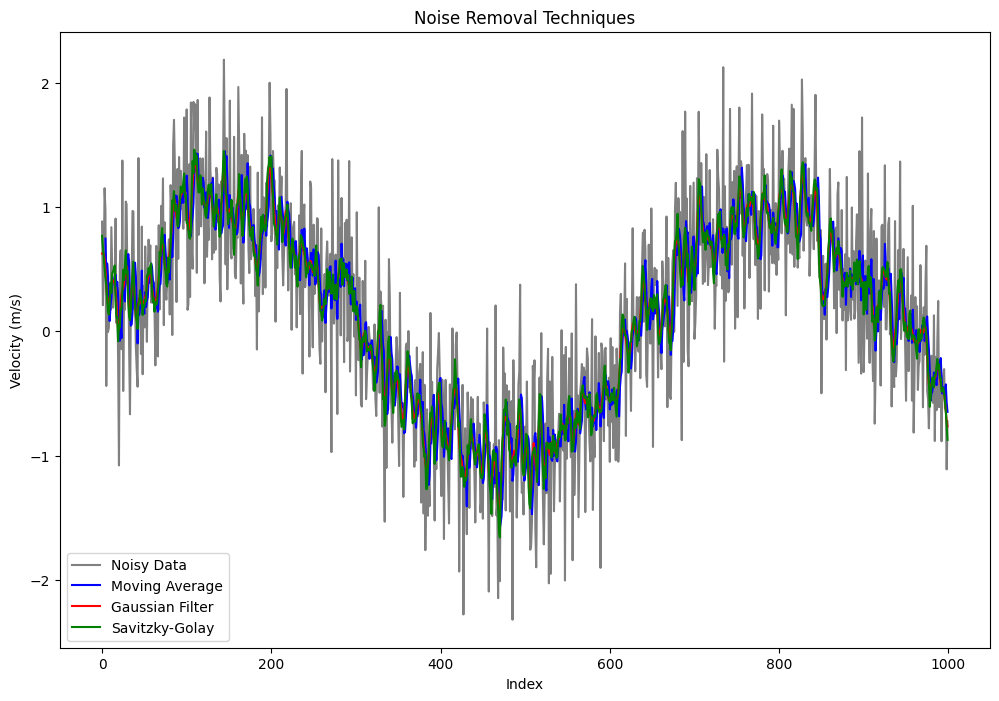

In [1]:
import numpy as np
import pandas as pd
import pywt
from scipy import ndimage
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Sample DataFrame for demonstration
# Replace this with your actual DataFrame
np.random.seed(0)
data_size = 1000
df = pd.DataFrame({
    'velocity(m/s)': np.sin(np.linspace(0, 10, data_size)) + np.random.normal(scale=0.5, size=data_size)
})

# 1. Moving Average Filter
def moving_average_filter(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 2. Gaussian Filter
def gaussian_filter(data, sigma):
    return ndimage.gaussian_filter1d(data, sigma=sigma)

# 3. Savitzky-Golay Filter
def savitzky_golay_filter(data, window_length, polyorder):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder)

# 4. Wavelet Denoising
def wavelet_denoising(data, wavelet='db1', level=1):
    pad_width = len(data) // 2
    data_padded = np.pad(data, pad_width, mode='reflect')
    
    coeffs = pywt.wavedec(data_padded, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(data_padded))) * (1 / np.sqrt(2))
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    
    denoised_padded = pywt.waverec(coeffs, wavelet)
    
    return denoised_padded[pad_width:-pad_width]

# Apply filters to DataFrame
window_size = 5
sigma = 2
window_length = 11
polyorder = 2

df['velocity_ma'] = np.nan
df['velocity_ma'].iloc[window_size-1:] = moving_average_filter(df['velocity(m/s)'], window_size)

df['velocity_gaussian'] = gaussian_filter(df['velocity(m/s)'], sigma)

df['velocity_sg'] = savitzky_golay_filter(df['velocity(m/s)'], window_length, polyorder)

df['velocity_wavelet'] = wavelet_denoising(df['velocity(m/s)'].values, wavelet='db1', level=2)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['velocity(m/s)'], label='Noisy Data', color='gray')
plt.plot(df.index, df['velocity_ma'], label='Moving Average', color='blue')
plt.plot(df.index, df['velocity_gaussian'], label='Gaussian Filter', color='red')
plt.plot(df.index, df['velocity_sg'], label='Savitzky-Golay', color='green')
# plt.plot(df.index, df['velocity_wavelet'], label='Wavelet Denoising', color='purple')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Velocity (m/s)')
plt.title('Noise Removal Techniques')
plt.show()


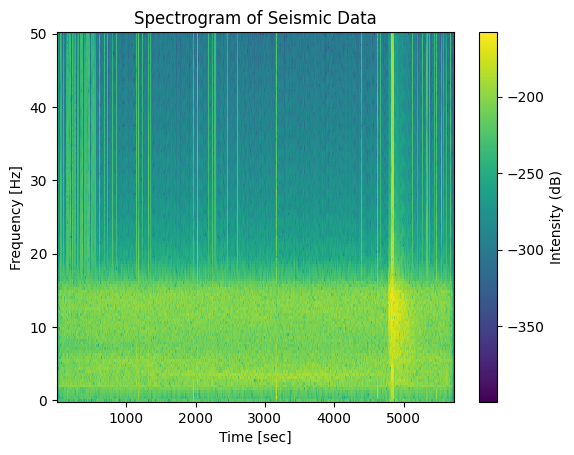

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram



# Extract the seismic data (for example, from a column named 'velocity(m/s)')
data = df['velocity(m/s)'].values

# Define the sampling rate (in Hz) - you'll need to know the correct sampling rate for your data
fs = 100  # Example: 100 Hz sampling rate, adjust based on your data

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(data, fs=fs)

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Seismic Data')
plt.colorbar(label='Intensity (dB)')
plt.show()
